# Homework 5: Precipitation Nowcasting using Neural Networks

In this exercise, you are going to build a set of deep learning models on a real world task using PyTorch. PyTorch is an open source machine learning framework based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab (FAIR).

## Setting up to use the gpu  

Before we start, we need to change the environment of Colab to use GPU. Do so by:

Runtime -> Change runtime type -> Hardware accelerator -> GPU

## Deep Neural Networks with PyTorch ##

To complete this exercise, you will need to build deep learning models for precipitation nowcasting. You will build a subset of the models shown below:
- Fully Connected (Feedforward) Neural Network
- Two-Dimentional Convolution Neural Network (2D-CNN)
- Recurrent Neural Network with Gated Recurrent Unit (GRU)

and one more model of your choice to achieve the highest score possible.

We provide the code for data cleaning and some starter code for PyTorch in this notebook but feel free to modify those parts to suit your needs. Feel free to use additional libraries (e.g. scikit-learn) as long as you have a model for each type mentioned above.

This notebook assumes you have already installed PyTorch with python3 and had GPU enabled. If you run this exercise on Colab you are all set.

## Precipitation Nowcasting ##

Precipitation nowcasting is the the task of predicting the amount of rainfall in a certain region given some kind of sensor data.  The term nowcasting refers to tasks that try to predict the current or near future conditions (within 6 hours).

You will be given satellite images in 3 different bands covering a 5 by 5 region from different parts of Thailand. In other words, your input will be a 5x5x3 image. Your task is to predict the amount of rainfall in the center pixel. You will first do the prediction using just a simple fully-connected neural network that view each pixel as different input features.

Since the your input is basically an image, we will then view the input as an image and apply CNN to do the prediction. Finally, we can also add a time component since weather prediction can benefit greatly using previous time frames. Each data point actually contain 5 time steps, so each input data point has a size of 5x5x5x3 (time x height x width x channel), and the output data has a size of 5 (time). You will use this time information when you work with RNNs.

Finally, we would like to thank the Thai Meteorological Department for providing the data for this assignment.

In [1]:
!nvidia-smi

Sat Feb 14 22:31:58 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 576.88                 Driver Version: 576.88         CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 5060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   36C    P3             20W /  145W |    1623MiB /   8151MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# For summarizing and visualizing models
!pip install torchinfo
!pip install torchviz

## Weights and Biases

[Weights and Biases](https://docs.wandb.ai/company) (wandb) is an experiment tracking tool for machine learning. It can log and visualize experiments in real time. It supports many popular ML frameworks, and obviously PyTorch is one of them. In this notebook you will learn how to log general metrics like losses, parameter distributions, and gradient distribution with wandb.

To install wandb, run the cell below

In [3]:
!pip install wandb

## Setup

1. Register [Wandb account](https://wandb.ai/login?signup=true) (and confirm your email)

2. `wandb login` and copy paste the API key when prompt

In [4]:
!wandb login

wandb: Currently logged in as: faithcr (faithcr-chulalongkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [5]:
import os
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import urllib
import wandb
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from sklearn import preprocessing
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchinfo import summary
from tqdm.notebook import tqdm

torch.__version__

'2.9.1+cu128'

## Loading the data

The data is on huggingface, a website that allows people to share datasets and pretrained models.

In [6]:
from huggingface_hub import hf_hub_download
hf_hub_download(repo_id="ecitslos/HWnowcastingdata", filename="nowcastingHWdataset.tar.gz", repo_type="dataset", local_dir=".")

'nowcastingHWdataset.tar.gz'

In [7]:
import os
print(os.getcwd())
print(os.listdir())

d:\Chula\2110573-PATT-RECOG\05_PyTorch
['.cache', 'dataset', 'HW5_Precipitation_Nowcasting_PyTorch_Student_2026.ipynb', 'HW5_template.ipynb', 'model_best.pth.tar', 'model_best_noise.pth.tar', 'model_cnn.pth.tar', 'model_ff.pth.tar', 'model_gru.pth.tar', 'model_tfm.pth.tar', 'model_wd.pth.tar', 'nowcastingHWdataset.tar.gz', 'wandb']


In [8]:
!tar -xvf nowcastingHWdataset.tar.gz

x dataset/features-m10.pk
x dataset/features-m6.pk
x dataset/features-m7.pk
x dataset/features-m8.pk
x dataset/features-m9.pk
x dataset/labels-m10.pk
x dataset/labels-m6.pk
x dataset/labels-m7.pk
x dataset/labels-m8.pk
x dataset/labels-m9.pk


# Data Explanation #

The data is an hourly measurement of water vapor in the atmosphere, and two infrared measurements of cloud imagery on a latitude-longitude coordinate. Each measurement is illustrated below as an image. These three features are included as different channels in your input data.

<img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/wvapor.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud1.png" width="200"> <img src="https://raw.githubusercontent.com/burin-n/pattern-recognition/master/HW4/images/cloud2.png" width="200">

We also provide the hourly precipitation (rainfall) records in the month of June, July, August, September, and October from weather stations spreaded around the country. A 5x5 grid around each weather station at a particular time will be paired with the precipitation recorded at the corresponding station as input and output data. Finally, five adjacent timesteps are stacked into one sequence.

The month of June-August are provided as training data, while the months of September and October are used as validation and test sets, respectively.


# Reading data

In [9]:
def read_data(months, data_dir='dataset'):
    features = np.array([], dtype=np.float32).reshape(0,5,5,5,3)
    labels = np.array([], dtype=np.float32).reshape(0,5)
    for m in months:
        filename = 'features-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            features_temp = pickle.load(file)
        features = np.concatenate((features, features_temp), axis=0)

        filename = 'labels-m{}.pk'.format(m)
        with open(os.path.join(data_dir,filename), 'rb') as file:
            labels_temp = pickle.load(file)
        labels = np.concatenate((labels, labels_temp), axis=0)

    return features, labels

In [10]:
# use data from month 6,7,8 as training set
x_train, y_train = read_data(months=[6,7,8])

# use data from month 9 as validation set
x_val, y_val = read_data(months=[9])

# use data from month 10 as test set
x_test, y_test = read_data(months=[10])

print('x_train shape:',x_train.shape)
print('y_train shape:', y_train.shape, '\n')
print('x_val shape:',x_val.shape)
print('y_val shape:', y_val.shape, '\n')
print('x_test shape:',x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (229548, 5, 5, 5, 3)
y_train shape: (229548, 5) 

x_val shape: (92839, 5, 5, 5, 3)
y_val shape: (92839, 5) 

x_test shape: (111715, 5, 5, 5, 3)
y_test shape: (111715, 5)


**features**
- dim 0: number of entries
- dim 1: number of time-steps in ascending order
- dim 2,3: a 5x5 grid around rain-measued station
- dim 4: water vapor and two cloud imagenaries

**labels**
- dim 0: number of entries
- dim 1: number of precipitation for each time-step

# Three-Layer Feedforward Neural Networks

In [11]:
# Dataset need to be reshaped to make it suitable for feedforword model
def preprocess_for_ff(x_train, y_train, x_val, y_val):
    x_train_ff = x_train.reshape((-1, 5*5*3))
    y_train_ff = y_train.reshape((-1, 1))
    x_val_ff = x_val.reshape((-1, 5*5*3))
    y_val_ff = y_val.reshape((-1, 1))
    x_test_ff = x_test.reshape((-1, 5*5*3))
    y_test_ff = y_test.reshape((-1, 1))

    return x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff

x_train_ff, y_train_ff, x_val_ff, y_val_ff, x_test_ff, y_test_ff = preprocess_for_ff(x_train, y_train, x_val, y_val)
print(x_train_ff.shape, y_train_ff.shape)
print(x_val_ff.shape, y_val_ff.shape)
print(x_test_ff.shape, y_test_ff.shape)

(1147740, 75) (1147740, 1)
(464195, 75) (464195, 1)
(558575, 75) (558575, 1)


### T1

Explain each line of code in the function preprocess_for_ff()

**Ans:**

    1: We break the dimension of time to be one row of 
    data for each time.

    2: Apply the break of dimension of time to be one 
    row of data for tha labels.

    3, 4, 5, 6: apply the same for validation and test set.

## Dataset

To prepare a DataLoader in order to feed data into the model, we need to create a `torch.utils.data.Dataset` object first. (Learn more about it [here](https://pytorch.org/docs/stable/data.html#map-style-datasets))

Dataset is a simple class that the DataLoader will get data from, most of its functionality comes from `__getitem__(self, index)` method, which will return a single data point (both input and label). In real world scenarios the method can do some other stuffs such as

1. Load images

If your input (x) are images. Oftentimes you won't be able to fit all the training images into your RAM. Thus, you should pass an array (or list) of image path into the dataloader, and the `__getitem__` will be the one who dynamically loads the actual image from the harddisk for you.

2. Data Normalization

Data normalization helps improve stability of training. Unnormalized data can cause gradients to explode. There are many variants of normalization, but in this notebook we will use either minmax or z-score (std) normalization. Read [this](https://developers.google.com/machine-learning/data-prep/transform/normalization) (or google) if you wish to learn more about data normalization.

3. Data Augmentation

In computer vision, you might want to apply small changes to the images you use in training (adjust brightness, contrast, rotation) so that the model will generalize better on unseen data. There are two kinds of augmentation: static and dynamic. Static augmentation will augment images and save to disk as a new dataset. On the other hand, rather than applying the change initially and use the same change on each image every epoch, dynamic augmentation will augment each data differently for each epoch. Note that augmentation is usually done on the CPU and you might be bounded by the CPU instead. PyTorch has a dedicated [documentation about data augmentation](https://pytorch.org/vision/master/transforms.html) if you want to know more.

In [12]:
class RainfallDatasetFF(Dataset):
    def __init__(self, x, y, normalizer):
        self.x = x.astype(np.float32)
        self.y = y.astype(np.float32)
        self.normalizer = normalizer
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index] # Retrieve data
        x = self.normalizer.transform(x.reshape(1, -1)) # Normalize
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

In [13]:
def normalizer_std(X):
    scaler = preprocessing.StandardScaler().fit(X)
    return scaler

def normalizer_minmax(X):
    scaler = preprocessing.MinMaxScaler().fit(X)
    return scaler

In [14]:
normalizer = normalizer_std(x_train_ff) # We will normalize everything based on x_train

train_dataset = RainfallDatasetFF(x_train_ff, y_train_ff, normalizer)
val_dataset = RainfallDatasetFF(x_val_ff, y_val_ff, normalizer)
test_dataset = RainfallDatasetFF(x_test_ff, y_test_ff, normalizer)

(1147740, 75)
(1147740, 1)
(464195, 75)
(464195, 1)
(558575, 75)
(558575, 1)


## DataLoader

DataLoader feeds data from our dataset into the model. We can freely customize batch size, data shuffle for each data split, and much more with DataLoader class. If you're curious about what can you do with PyTorch's DataLoader, you can check [this documentation](https://pytorch.org/docs/stable/data.html)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=1024, shuffle=False, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False, pin_memory=True)

## Loss Function

PyTorch has many loss functions readily available for use. We can also write our own custom loss function as well. But for now, we will use [PyTorch's built-in mean squared error loss ](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)

In [16]:
loss_fn = nn.MSELoss()

### T2

Why is the loss MSE?

**Ans:** Because we are predicting the rainfall which is numerical.

## Device

Unlike Tensorflow/Keras, PyTorch allows user to freely put any Tensor or objects (loss functions, models, optimizers, etc.) in CPU or GPU. By default, all objects created will be in CPU. In order to use GPU we will have to supply `device = torch.device("cuda")` into the objects to move it to GPU. You will usually see the syntax like `object.to(device)` for moving CPU object to GPU, or `o = Object(..., device=device)` to create the object in the GPU.

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Model

Below, the code for creating a 3-layers fully connected neural network in PyTorch is provided. Run the code and make sure you understand what you are doing. Then, report the results.

In [18]:
class FeedForwardNN(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNN, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hd2 = F.relu(self.ff2(hd1))
        y = F.relu(self.ff3(hd2))
        y = self.out(y)
        return y.reshape(-1, 1)

### T3

What is the activation function in the final dense layer? and why? Do you think there is a better activation function for the final layer?

**Ans:**

In [19]:
# Hyperparameters and other configs
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2, # new lr = old lr * 0.2
    'scheduler_patience': 2, # wait for 2 no improvements epochs before reducing LR
    'scheduler_min_lr': 1e-4, # not reduce LR lower than this
    'epochs': 10
}

# Model
model_ff = FeedForwardNN(hidden_size=config['hidden_size'])
model_ff = model_ff.to(device)
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr']) # Adam: adaptive learning rate per parameter
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

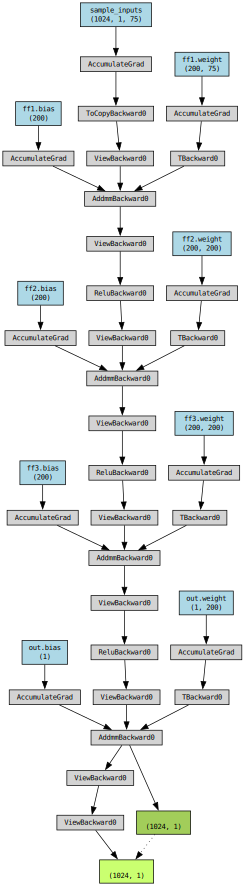

In [20]:
from torchviz import make_dot
# Visualize model with torchviz
sample_inputs = next(iter(train_loader))[0].requires_grad_(True)
sample_y = model_ff(sample_inputs.to(device))
make_dot(sample_y, params=dict(list(model_ff.named_parameters())+[('sample_inputs', sample_inputs)]))

In [21]:
summary(model_ff, input_size=(1024, 75))

Layer (type:depth-idx)                   Output Shape              Param #
FeedForwardNN                            [1024, 1]                 --
├─Linear: 1-1                            [1024, 200]               15,200
├─Linear: 1-2                            [1024, 200]               40,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 95,801
Trainable params: 95,801
Non-trainable params: 0
Total mult-adds (M): 98.10
Input size (MB): 0.31
Forward/backward pass size (MB): 4.92
Params size (MB): 0.38
Estimated Total Size (MB): 5.61

### T4

Explain why the first linear layer has number of parameters = 15200

**Ans:** 

    There's 200 nodes with 75 inputs each + 1 bias, 
    so it is (75 + 1) * 200 = 15,200. 
    The 1024 is the batch size.

# Training

In [22]:
train_losses = []
val_losses = []
learning_rates = []

# Start wandb run
wandb.init(
    project='precipitation-nowcasting-2026',
    config=config,
)

# Log parameters and gradients
# This makes the training slow. Do this when you are debugging only.
# You should avoid doing this when doing serious training.
wandb.watch(model_ff, log='all')

for epoch in range(config['epochs']):  # loop over the dataset multiple times

    # Training
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    # Flag model as training. Some layers behave differently in training and
    # inference modes, such as dropout, BN, etc.
    model_ff.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, y_true) in enumerate(tqdm(train_loader)):
        # Transfer data from cpu to gpu
        inputs = inputs.to(device)
        y_true = y_true.to(device)

        # Reset the gradient
        optimizer.zero_grad()

        # Predict
        y_pred = model_ff(inputs)

        # Calculate loss
        loss = loss_fn(y_pred, y_true)

        # Compute gradient
        loss.backward()

        # Update parameters
        optimizer.step()

        # Log stuff
        train_loss.append(loss)

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)

    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_ff.eval()
    with torch.no_grad(): # No gradient is required during validation
        print(f"Validating epoch {epoch+1}")
        val_loss = []
        for i, (inputs, y_true) in enumerate(tqdm(val_loader)):
            # Transfer data from cpu to gpu
            inputs = inputs.to(device)
            y_true = y_true.to(device)

            # Predict
            y_pred = model_ff(inputs)

            # Calculate loss
            loss = loss_fn(y_pred, y_true)

            # Log stuff
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        # LR adjustment with scheduler
        scheduler.step(avg_val_loss)

        # Save checkpoint if val_loss is the best we got
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_ff.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_ff.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

wandb: Currently logged in as: faithcr (faithcr-chulalongkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9326
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6579
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9220
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6588
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9206
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6572
Saving new best model..
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9204
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6593
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9207
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6577
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9204
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6581
Training epoch 7...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9197
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6576
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9190
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6567
Saving new best model..
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9186
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6565
Saving new best model..
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9187
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6577


lr,██████▁▁▁▁
train_loss,█▃▂▂▂▂▂▁▁▁
val_loss,▅▇▃█▄▅▄▁▁▄
lr,0.002
train_loss,1.91873
val_loss,1.65766


Finished Training


You might want to download the saved model (model_ff.pth.tar) for later uses if you are running on Colab.

### T5

Plot loss and val_loss as a function of epochs.

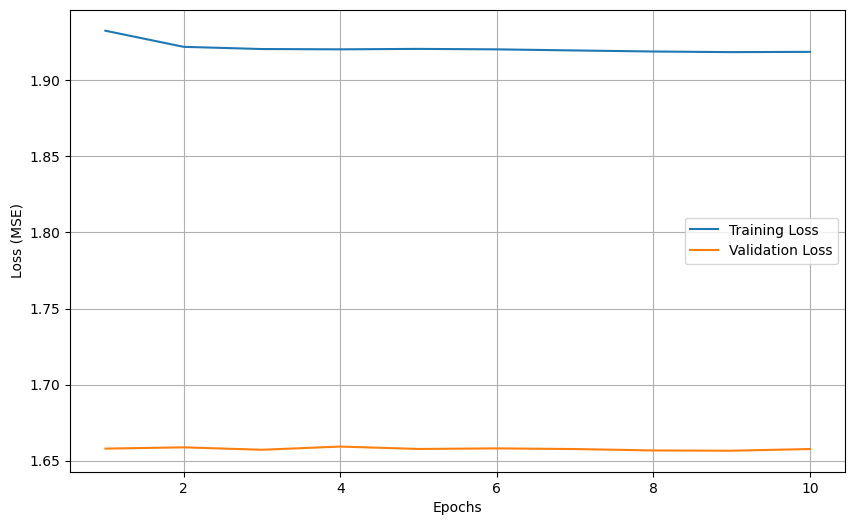

In [23]:
x = np.arange(1, 11, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label='Training Loss')
plt.plot(x, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

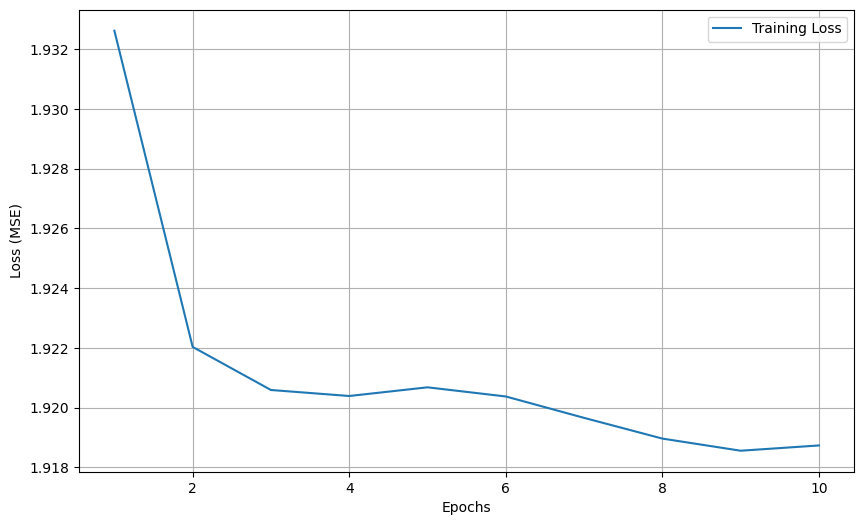

In [24]:
x = np.arange(1, 11, 1)

plt.figure(figsize=(10, 6))
plt.plot(x, train_losses, label='Training Loss')
# plt.plot(x, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

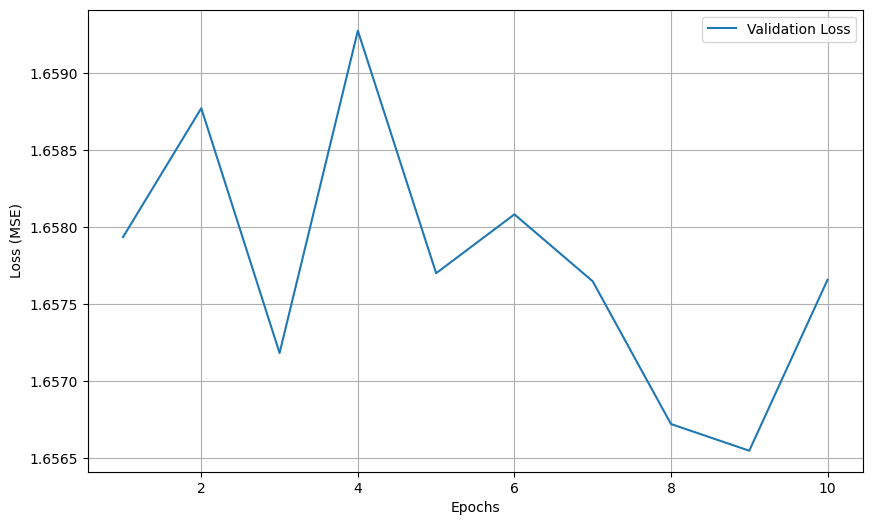

In [25]:
x = np.arange(1, 11, 1)

plt.figure(figsize=(10, 6))
# plt.plot(x, train_losses, label='Training Loss')
plt.plot(x, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

### T6

When does the model start to overfit?

**Ans:**

    Epoch 2, 4, 6, 9

### T7

Plot the learning rate as a function of the epochs.

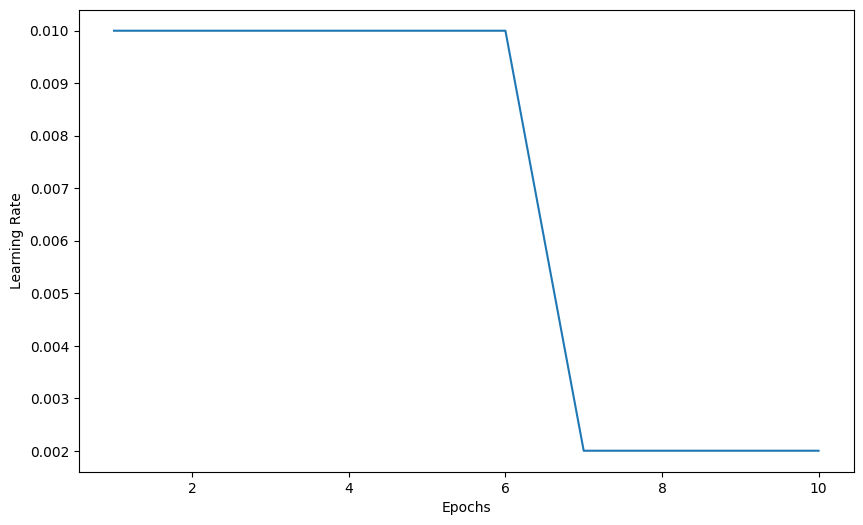

In [26]:
plt.figure(figsize=(10, 6))
plt.plot(x, learning_rates, label="Learning Rate")
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.show()

### T8

What makes the learning rate change?
(hint: try to understand the scheduler [ReduceLROnPlateau](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html))


**Ans:** 

    Our patience is 2 which the validation loss 
    in epochs 2, 3 is no better but still in patience, 
    but when the epoch 4 is also not better then the 
    learning rate decreases.

# Load Model

Use the code snippet below to load the model you just trained

In [27]:
checkpoint = torch.load('model_ff.pth.tar')
loaded_model = FeedForwardNN(hidden_size=config['hidden_size']) # Create model object
loaded_model.load_state_dict(checkpoint['model']) # Load weights
print(f"Loaded epoch {checkpoint['epoch']} model")

Loaded epoch 8 model


# A more complex scheduling

The scheduler can be very complicated and you can write your own heuristic for it.

### T9

Implement a custom learning rate scheduler that behaves like the following graph.

You might want to learn how to use [PyTorch's built-in learning rate schedulers](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) in order to build your own.

Learning rate should be function of epoch.

![](https://raw.githubusercontent.com/pjumruspun/ComProg2021-Workshop/main/graph.png)

In [28]:
# Implement scheduler here
class MyScheduler():
    def __init__(self, optimizer: torch.optim.Optimizer):
        self.optimizer = optimizer

    def step(self, epoch):
        # Changes the learning rate here
        if (epoch >= 7):
            slope = (0.0001 - 0.001) / (9 - 7)
        elif (epoch >= 6):
            slope = (0.001 - 0.0005) / (7 - 6)
        elif (epoch >= 3):
            slope = (0.0005 - 0.001) / (6 - 3) 
        else:
            slope = 0.0003
        
        self.optimizer.param_groups[0]['lr'] += slope        

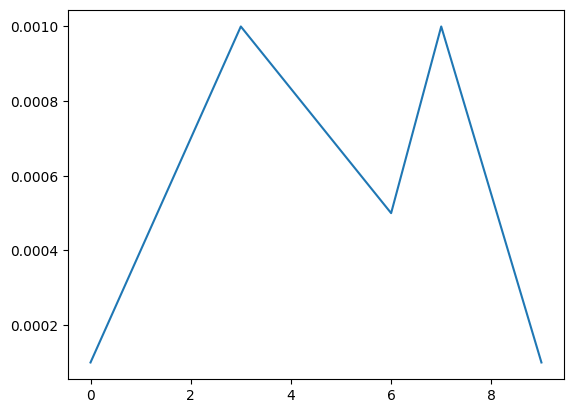

In [29]:
# Now train with your scheduler
# my_scheduler = MyScheduler(...)
config = {
    'architecture': 'feedforward',
    'lr': 0.0001,
    'hidden_size': 200,
    'epochs': 10
}
optimizer = torch.optim.Adam(model_ff.parameters(), lr=config['lr'])
my_scheduler = MyScheduler(optimizer)
test_lr = []
for epoch in range(config['epochs']):
    test_lr.append(optimizer.param_groups[0]['lr'])
    my_scheduler.step(epoch)
plt.plot(test_lr, label='learning rate')

# [Optional] Wandb #

You should now have a project in wandb with the name `precipitation-nowcasting`, which you should see the latest run you just finished inside the project. If you look into the run, you should be able to see plots of learning rate, train loss, val loss in the `Charts` section. Below it should be `Gradients` and `Parameters` section.

# Wandb Observation #

### OT1

Write your own interpretation of the logs from this example. A simple sentence or two for each section is sufficient.

**Your answer:**

    Gradient: Average of Gradient is likely to be zero. 
    It continues to learn as the distribution of the 
    gradients is still visible, meaning it still learning.
    Parameters: Some parameters distribution stays the same 
    in 2-3 epochs and start to change again. This might 
    due to the change of learning rate.

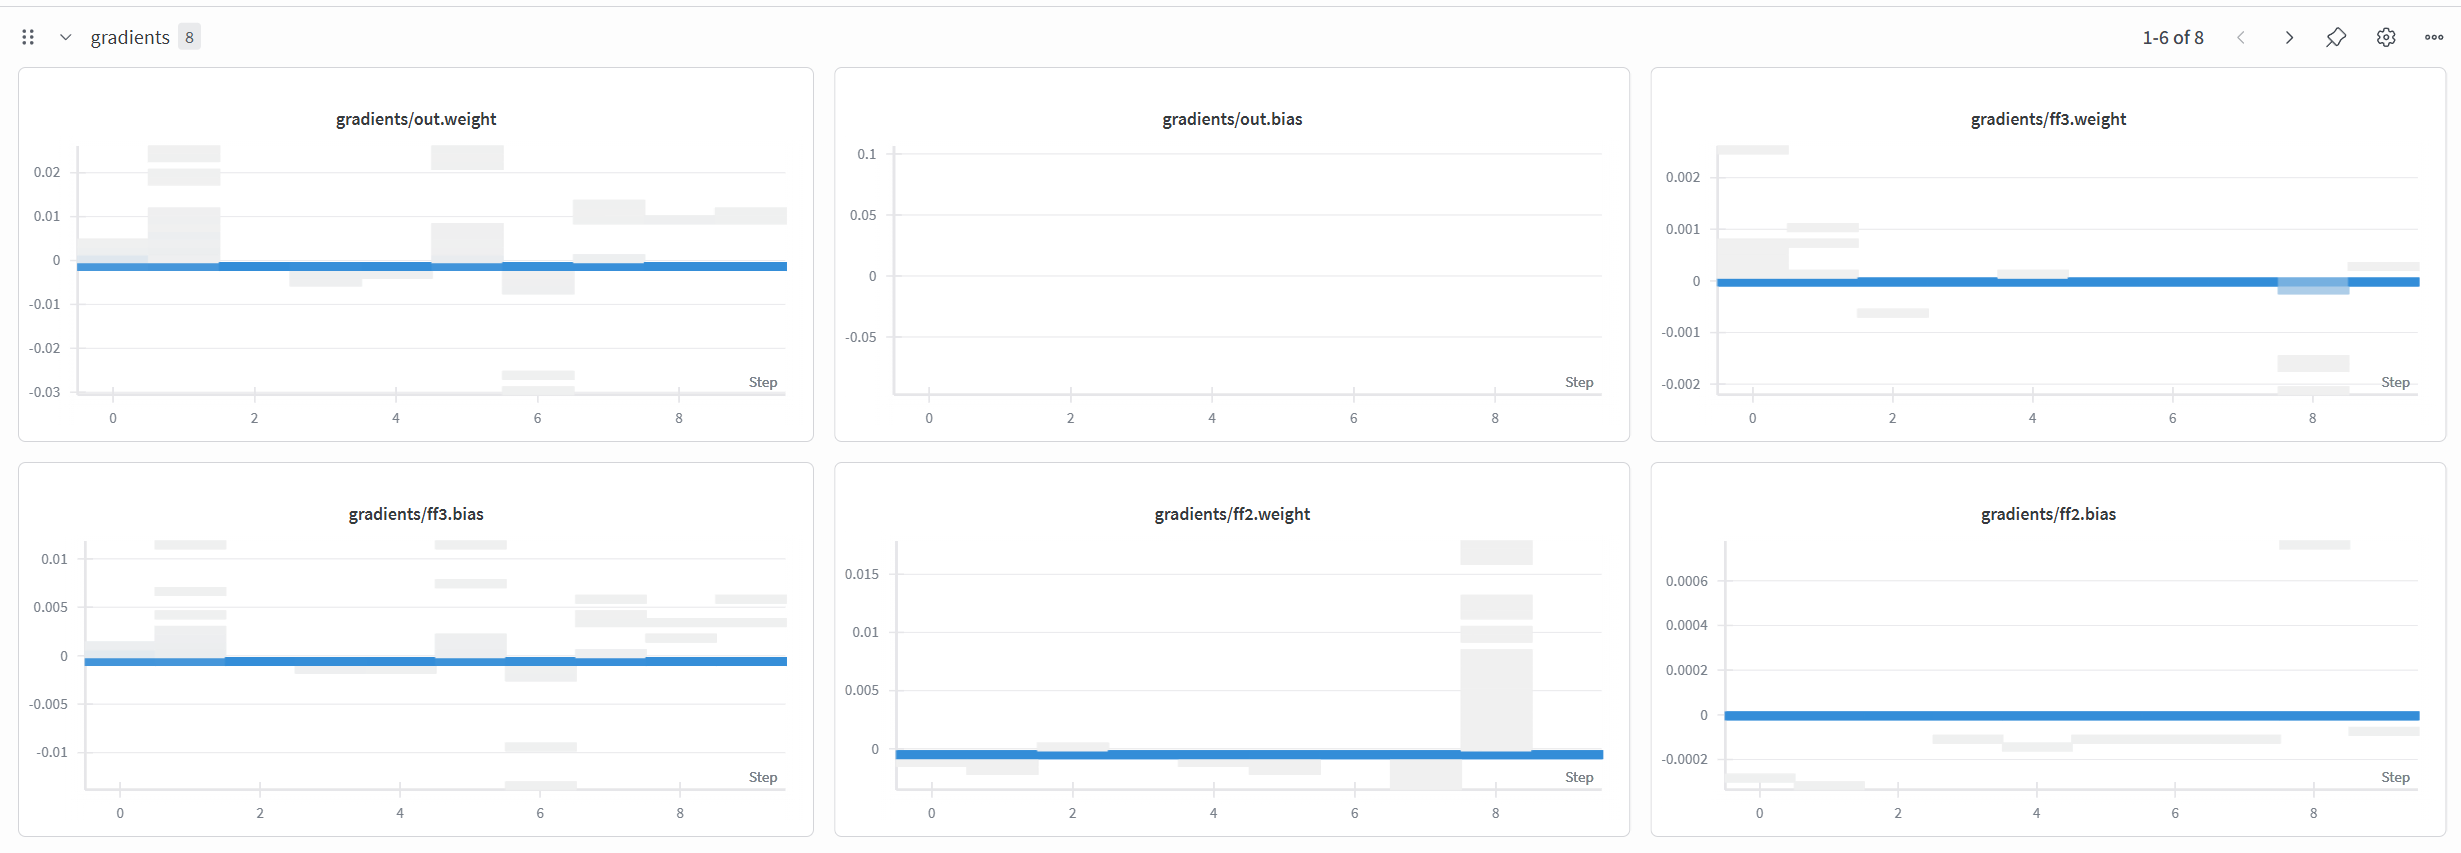

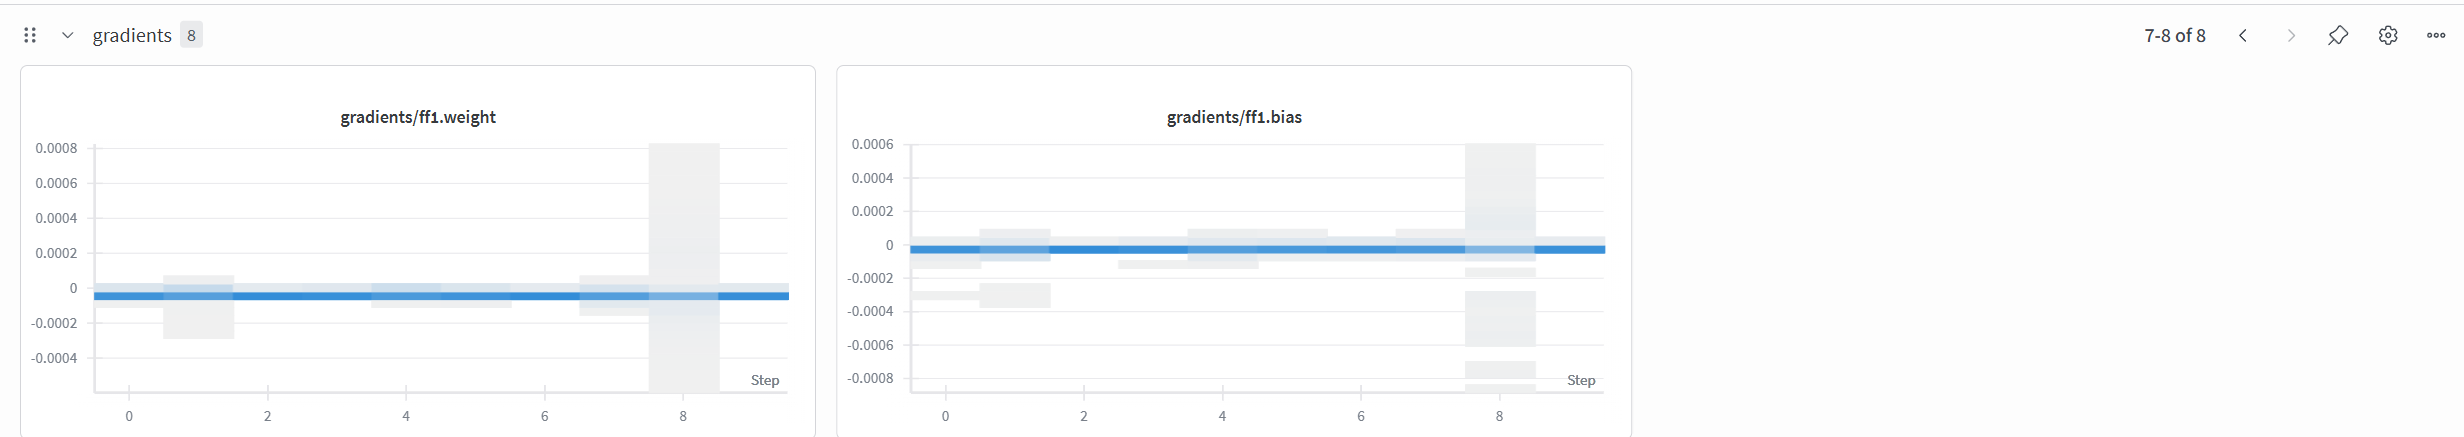

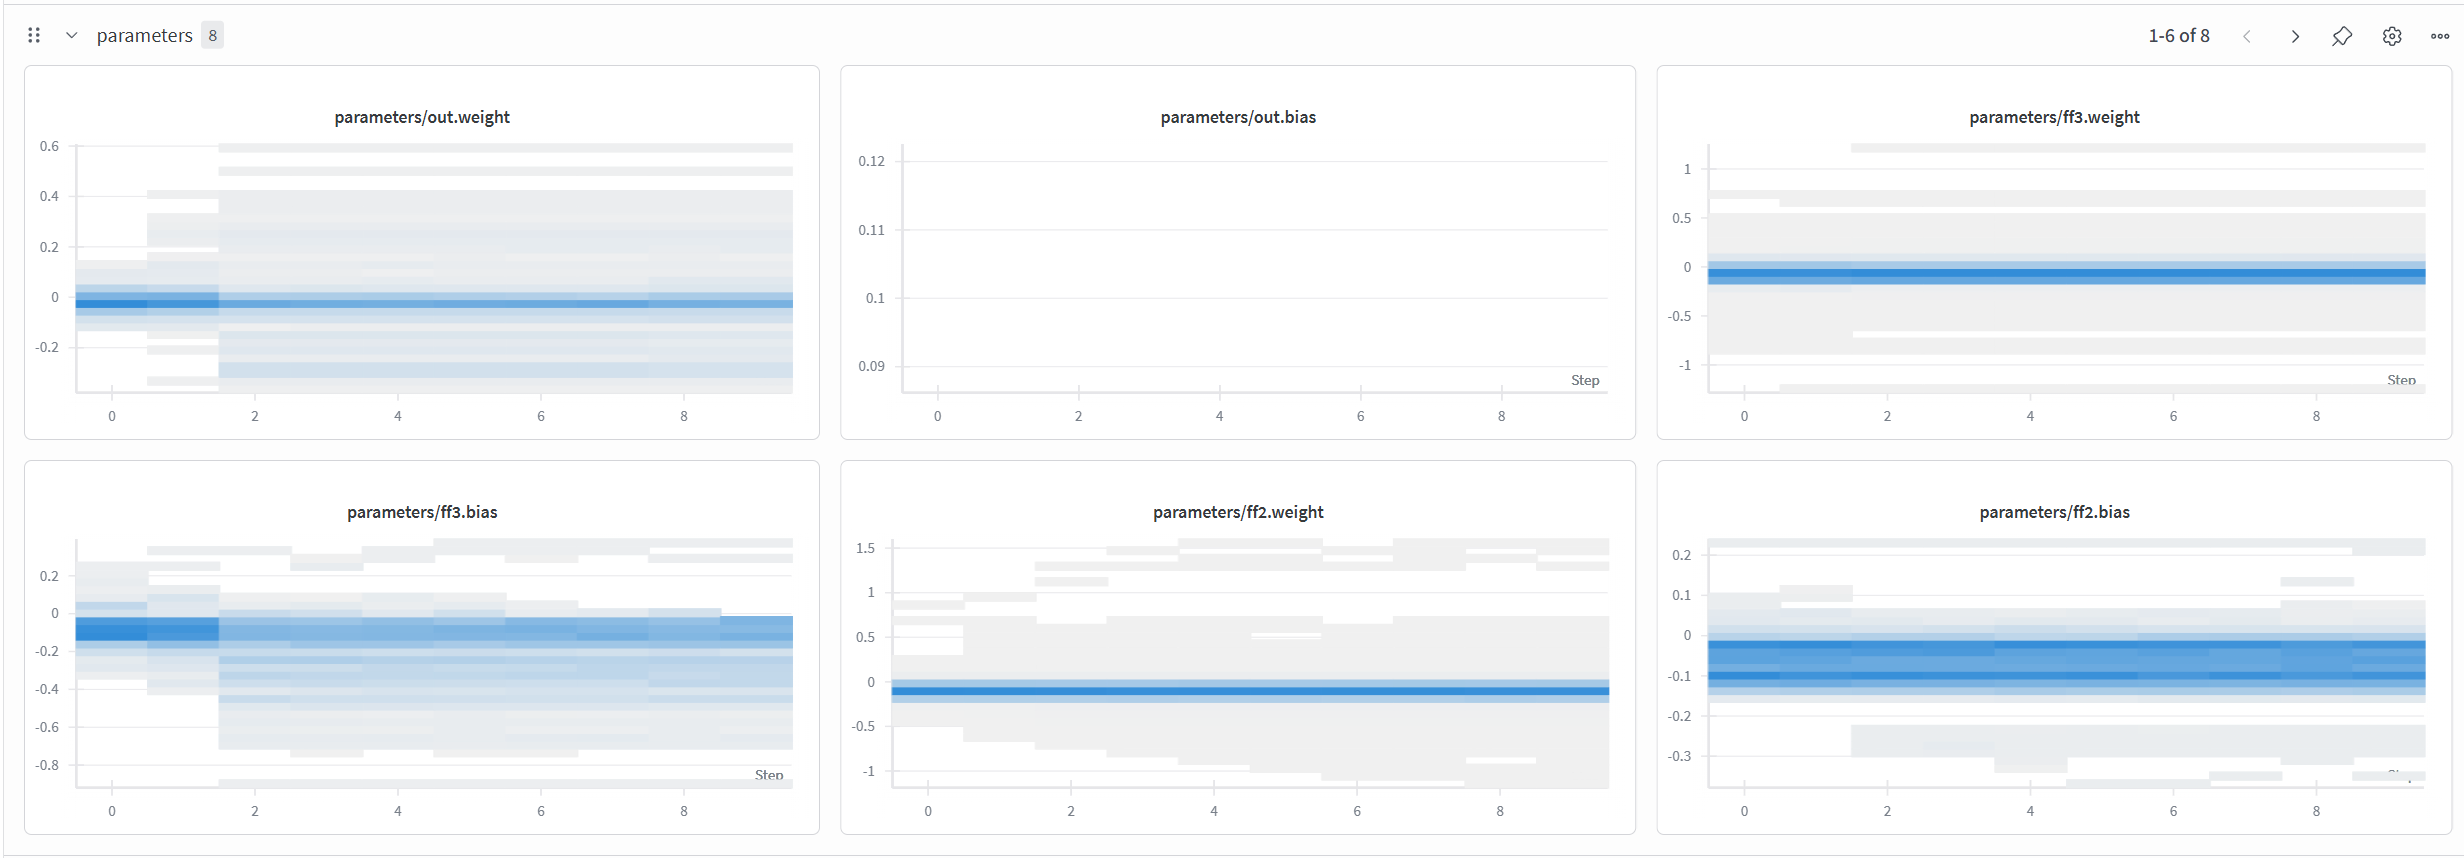

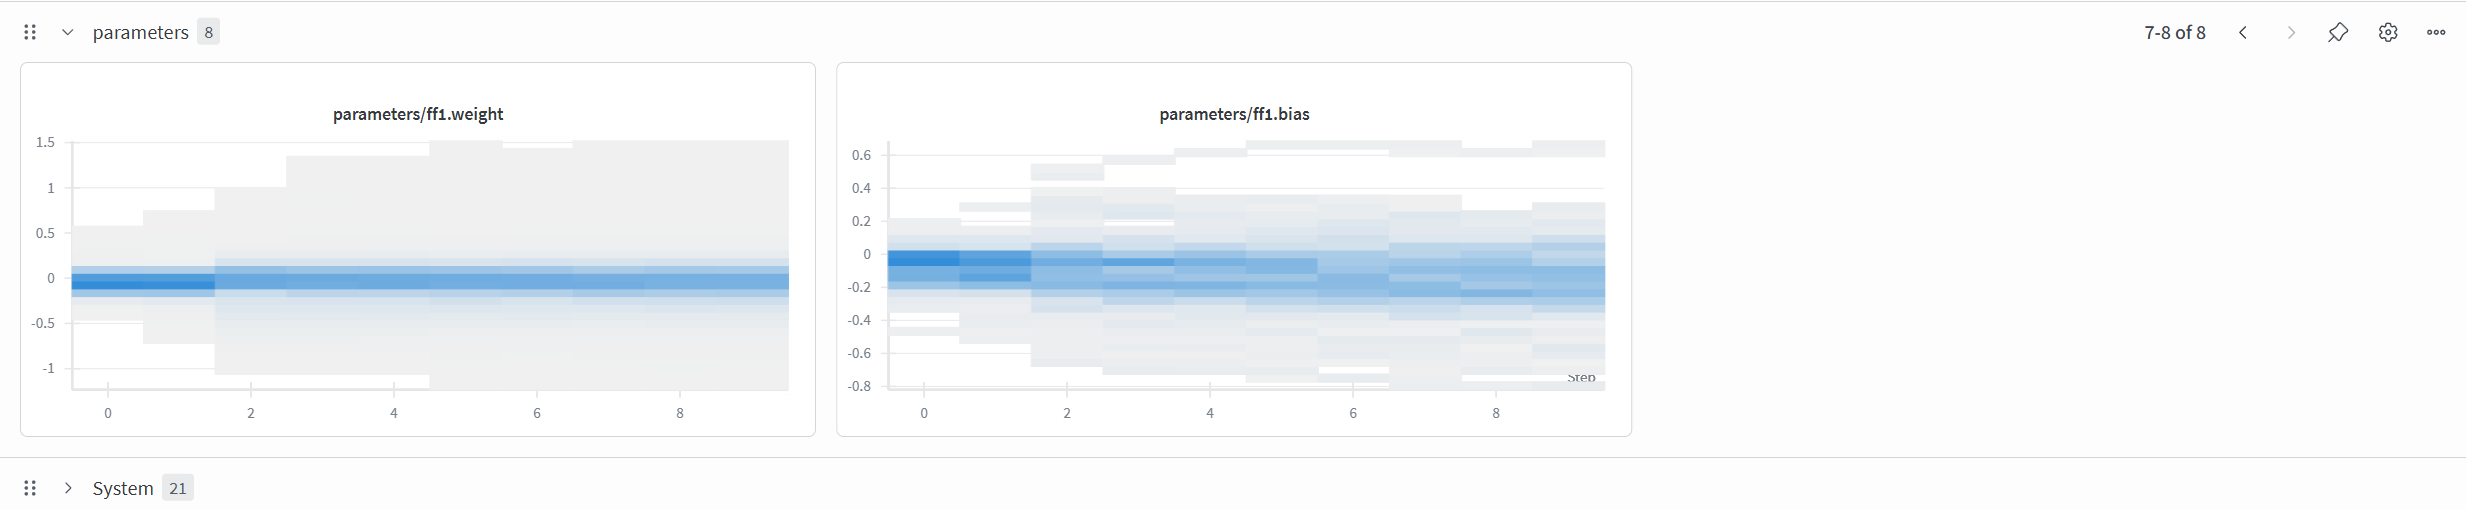

# Evaluation

In [30]:
################################################################################
# TODO#10:                                                                     #
# Write a function to evaluate your model. Your function must predicts         #
# using the input model and return mean square error of the model.             #
#                                                                              #
# Hint: Read how to use PyTorch's MSE Loss                                     #
# https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def evaluate(data_loader, model):
    """
    Evaluate model on validation data given by data_loader
    """
    # write code here
    loss_fn = nn.MSELoss()

    model.eval()

    device = next(model.parameters()).device
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs)

            loss = loss_fn(outputs, targets)

            total_loss += loss.item()
            num_batches += 1

    mse = total_loss / num_batches
    
    return torch.tensor(mse)

In [31]:
# We will use majority rule as a baseline.
def majority_baseline(label_set):
    unique, counts = np.unique(label_set, return_counts=True)
    majority = unique[np.argmax(counts)]
    baseline = 0
    label_set = label_set.reshape(-1,1)
    for r in label_set:
        baseline += (majority - r) ** 2 / len(label_set)
    return baseline

In [32]:
print('baseline')
print('train', majority_baseline(y_train))
print('validate', majority_baseline(y_val))

baseline
train [1.94397725]
validate [1.6746546]


In [33]:
model_ff = FeedForwardNN(hidden_size=config['hidden_size']) 
model_ff = model_ff.to(device)

checkpoint = torch.load('model_ff.pth.tar')
model_ff.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [34]:
print('FF-model')
print('train', evaluate(train_loader, model_ff).item())
print('validate', evaluate(val_loader, model_ff).item())

FF-model


train 1.918933391571045
validate 1.6565487384796143


# Dropout #

You might notice that the 3-layered feedforward does not use dropout at all. Now, try adding dropout (dropout rate of 20%) to the model, run, and report the result again.

To access PyTorch's dropout, use `nn.Dropout`. Read more about PyTorch's built-in Dropout layer [here](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)

In [35]:
################################################################################
# T11:                                                                     #
# Write a feedforward model with dropout                                       #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class FeedForwardNNwithDropout(nn.Module):
    def __init__(self, hidden_size=200):
        super(FeedForwardNNwithDropout, self).__init__()
        self.ff1 = nn.Linear(75, hidden_size)
        self.ff2 = nn.Linear(hidden_size, hidden_size)
        self.ff3 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        hd1 = F.relu(self.ff1(x))
        hdrop1 = self.dropout(hd1)
        hd2 = F.relu(self.ff2(hdrop1))
        hdrop2 = self.dropout(hd2)
        hd3 = F.relu(self.ff3(hdrop2))
        hdrop3 = self.dropout(hd3)
        y = self.out(hdrop3)
        return y.reshape(-1, 1)

In [36]:
################################################################################
# T12:                                                                     #
# Complete the code to train your dropout model                                #
################################################################################
print('start training ff dropout')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'feedforward',
    'lr': 0.01,
    'hidden_size': 200,
    'scheduler_factor': 0.2,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-4,
    'epochs': 10
}

model_wd = FeedForwardNNwithDropout(config['hidden_size'])
model_wd = model_wd.to(device)
optimizer = torch.optim.Adam(model_wd.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr']
)

run = wandb.init(
    project="precipitation-nowcasting",
    config=config,
)

train_losses = []
val_losses = []
learning_rates = []

wandb.watch(model_wd, log='all')

for epoch in range(config['epochs']):
    train_loss = []
    current_lr = optimizer.param_groups[0]['lr']
    learning_rates.append(current_lr)

    model_wd.train()

    print(f"Training epoch {epoch+1}...")
    print(f"Current LR: {current_lr}")

    for i, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        out = model_wd(inputs)

        loss = loss_fn(out, targets)
        loss.backward()

        optimizer.step()
        
        train_loss.append(loss)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    # Validation
    model_wd.eval()
    with torch.no_grad():
        print(f"Validating epoch {epoch+1}")
        val_loss = []

        for i, (inputs, targets) in enumerate(tqdm(val_loader)):
            inputs = inputs.to(device)
            targets = targets.to(device)

            out = model_wd(inputs)

            loss = loss_fn(out, targets)

            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)
        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            # Save whatever you want
            state = {
                'epoch': epoch,
                'model': model_wd.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'best_val_loss': best_val_loss,
            }

            print(f"Saving new best model..")
            torch.save(state, 'model_wd.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': current_lr,
    })

wandb.finish()
print('Finished Training')

start training ff dropout


Training epoch 1...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9356
Validating epoch 1


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6609
Saving new best model..
Training epoch 2...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9233
Validating epoch 2


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6607
Saving new best model..
Training epoch 3...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9235
Validating epoch 3


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6621
Training epoch 4...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9236
Validating epoch 4


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6603
Saving new best model..
Training epoch 5...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9241
Validating epoch 5


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6618
Training epoch 6...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9235
Validating epoch 6


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6607
Training epoch 7...
Current LR: 0.01


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9234
Validating epoch 7


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6604
Training epoch 8...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9234
Validating epoch 8


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6608
Training epoch 9...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9234
Validating epoch 9


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6607
Training epoch 10...
Current LR: 0.002


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9235
Validating epoch 10


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6610


lr,███████▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,▃▂█▁▇▂▁▃▂▃
lr,0.002
train_loss,1.92346
val_loss,1.66095


Finished Training


### T13

Plot the losses and MSE of the training and validation as before. Evaluate the dropout model's performance

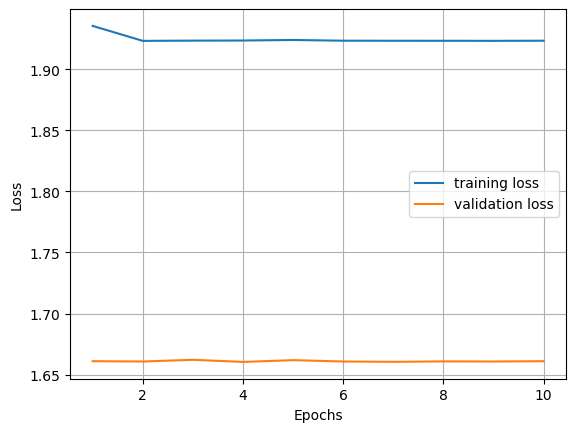

In [37]:
# Plot here
x = np.arange(1, 11, 1)
# losses
plt.plot(x, train_losses, label='training loss')
plt.plot(x, val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
model_wd = FeedForwardNNwithDropout(hidden_size=200) 
model_wd = model_wd.to(device)

checkpoint = torch.load('model_wd.pth.tar')
model_wd.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [39]:
# Evaluate
print("Drop out")
print("train,", evaluate(train_loader, model_wd).item())
print("validate,", evaluate(val_loader, model_wd).item())

Drop out


train, 1.9242751598358154
validate, 1.6603444814682007


# Convolution Neural Networks
Now let's try to incorporate the grid sturcture to your model. Instead of passing in vectors, we are going to pass in the 5x5 grid into the model (5lat x 5long x 3channel). You are going to implement you own 2d-convolution neural networks with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
Conv2DNN                                 --                        --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
==========================================================================================
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
```
These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         

Hint: You should read PyTorch documentation to see the list of available layers and options you can use.                         

In [40]:
################################################################################
# T14:                                                                     #
# Complete the code for preparing data for training CNN                        #
# Input for CNN should not have time step.                                     #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################

def preprocess_for_conv(x_train, y_train, x_val, y_val, x_test, y_test):
    x_train_conv = x_train.reshape((-1, 5, 5, 3))
    y_train_conv = y_train.reshape(-1, 1)
    x_val_conv = x_val.reshape((-1, 5, 5, 3))
    y_val_conv = y_val.reshape((-1, 1))
    x_test_conv = x_test.reshape((-1, 5, 5, 3))
    y_test_conv = y_test.reshape((-1, 1))

    return x_train_conv, y_train_conv, x_val_conv, y_val_conv, x_test_conv, y_test_conv

x_train_conv, y_train_conv, x_val_conv, y_val_conv, x_test_conv, y_test_conv = preprocess_for_conv(x_train, y_train, x_val, y_val, x_test, y_test)
print(x_train_conv.shape, y_train_conv.shape)
print(x_val_conv.shape, y_val_conv.shape)
print(x_test_conv.shape, y_test_conv.shape)

# it has to be channel, height, width not height, width, channel
x_train_conv = torch.tensor(x_train_conv).permute(0, 3, 1, 2).float()
x_val_conv = torch.tensor(x_val_conv).permute(0, 3, 1, 2).float()
x_test_conv = torch.tensor(x_test_conv).permute(0, 3, 1, 2).float()

class RainfallDatasetConv(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        print(self.x.shape)
        print(self.y.shape)

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

train_dataset_conv = RainfallDatasetConv(x_train_conv, y_train_conv)
val_dataset_conv = RainfallDatasetConv(x_val_conv, y_val_conv)
test_dataset_conv = RainfallDatasetConv(x_test_conv, y_test_conv)

train_loader_conv = DataLoader(train_dataset_conv, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_conv = DataLoader(val_dataset_conv, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_conv = DataLoader(test_dataset_conv, batch_size=1024, shuffle=False, pin_memory=True)

(1147740, 5, 5, 3) (1147740, 1)
(464195, 5, 5, 3) (464195, 1)
(558575, 5, 5, 3) (558575, 1)
torch.Size([1147740, 3, 5, 5])
(1147740, 1)
torch.Size([464195, 3, 5, 5])
(464195, 1)
torch.Size([558575, 3, 5, 5])
(558575, 1)


In [41]:
################################################################################
# T15:                                                                     #
# Write a PyTorch convolutional neural network model.                          #
# You might want to use the layer torch.flatten somewhere                      #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class ConvNN(nn.Module):
    def __init__(self, hidden_size=200, out_channels=200, kernel=3):
        super(ConvNN, self).__init__()
        self.conv = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel)
        # Flattened size = 200 * 3 * 3 = 1800
        self.d1 = nn.Linear(out_channels * kernel * kernel, hidden_size)
        self.d2 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, 1)

    def forward(self, x):
        fmap = F.relu(self.conv(x))
        fmap = fmap.flatten(start_dim=1)
        hd1 = F.relu(self.d1(fmap))
        hd2 = F.relu(self.d2(hd1))
        y = self.out(hd2)
        return y

In [42]:
model_cnn = ConvNN()
model_cnn = model_cnn.to(device)

summary(model_cnn, input_size=(1024, 3, 5, 5))

Layer (type:depth-idx)                   Output Shape              Param #
ConvNN                                   [1024, 1]                 --
├─Conv2d: 1-1                            [1024, 200, 3, 3]         5,600
├─Linear: 1-2                            [1024, 200]               360,200
├─Linear: 1-3                            [1024, 200]               40,200
├─Linear: 1-4                            [1024, 1]                 201
Total params: 406,201
Trainable params: 406,201
Non-trainable params: 0
Total mult-adds (M): 461.83
Input size (MB): 0.31
Forward/backward pass size (MB): 18.03
Params size (MB): 1.62
Estimated Total Size (MB): 19.96

In [43]:
################################################################################
# T16:                                                                     #
# Complete the code to train your cnn model                                    #
################################################################################
print('start training conv2d')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'CNN',
    'lr': 0.001,
    'hidden_size': 200,
    'epochs': 10,
    'scheduler_factor': 0.5,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-5,
}

optimizer = torch.optim.Adam(model_cnn.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min', 
    factor=config['scheduler_factor'], 
    patience=config['scheduler_patience'], 
    min_lr=config['scheduler_min_lr']
)

run = wandb.init(
    project="precipitation-nowcasting",     
    config=config,
)
wandb.watch(model_cnn, log='all')

train_losses = []
val_losses = []

for epoch in range(config['epochs']):
    train_loss = []
    model_cnn.train()

    print(f"Training epoch: {epoch}")
    for i, (inputs, targets) in enumerate(tqdm(train_loader_conv)):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    model_cnn.eval()
    with torch.no_grad():
        val_loss = []

        for i, (inputs, targets) in enumerate(tqdm(val_loader_conv)):
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()

            out = model_cnn(inputs)
            loss = loss_fn(out, targets)
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if (avg_val_loss < best_val_loss):
            state = {
                'epoch': epoch,
                'model': model_cnn.state_dict(),
                'optimizer': optimizer.state_dict(),
                'val_loss': avg_val_loss
            }
            print(f"Saving new best model..")
            torch.save(state, 'model_cnn.pth.tar')
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': optimizer.param_groups[0]['lr']
    })

wandb.finish()
print("Finished Training")

start training conv2d


Training epoch: 0


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 1 train loss: 11.8868


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 1 val loss: 1.7253
Saving new best model..
Training epoch: 1


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 2 train loss: 2.3212


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6645
Saving new best model..
Training epoch: 2


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9242


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6593
Saving new best model..
Training epoch: 3


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9710


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6624
Training epoch: 4


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9221


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6741
Training epoch: 5


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9212


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6609
Training epoch: 6


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9201


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6590
Saving new best model..
Training epoch: 7


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9205


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6611
Training epoch: 8


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9227


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6579
Saving new best model..
Training epoch: 9


  0%|          | 0/1121 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9201


  0%|          | 0/454 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6585


lr,█████▁▁▁▁▁
train_loss,█▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▃▁▁▁▁▁
lr,0.0005
train_loss,1.92011
val_loss,1.65848


Finished Training


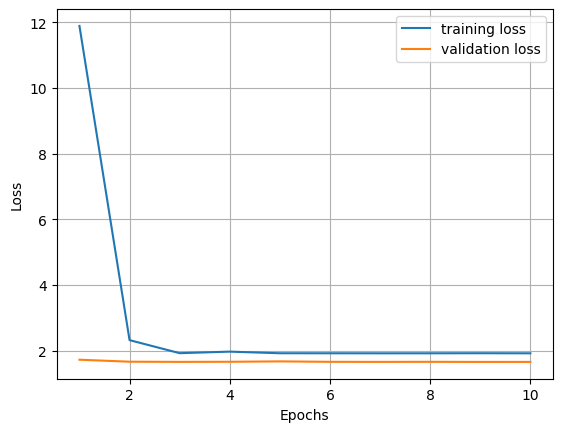

In [44]:
# Plot losses
# Plot here
x = np.arange(1, 11, 1)
# losses
plt.plot(x, train_losses, label='training loss')
plt.plot(x, val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
# Evaluate
model_cnn_clean = ConvNN()
model_cnn_clean = model_cnn_clean.to(device)

checkpoint = torch.load('model_cnn.pth.tar')
model_cnn_clean.load_state_dict(checkpoint['model'])

model_cnn_clean.eval()

print("CNN")
print("train,", evaluate(train_loader_conv, model_cnn_clean).item())
print("validate,", evaluate(val_loader_conv, model_cnn_clean).item())

CNN
train, 1.9191076755523682
validate, 1.6578830480575562


# [Optional] Gated Recurrent Units

Now, you want to add time steps into your model. Recall the original data has 5 time steps per item. You are going to pass in a data of the form 5 timesteps x 75data. This can be done using a GRU layer. Implement you own GRU network with the following structure.
```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
GRUModel                                 --                        --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
==========================================================================================
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
```


These parameters are simple guidelines to save your time.    
You can play with them in the final section which you can choose any normalization methods, activation function, as well as any hyperparameter the way you want.         
The result should be better than the feedforward model and at least on par with your CNN model.    

Do consult PyTorch documentation on how to use [GRUs](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html).


In [46]:
################################################################################
# OT2:                                                                     #
# Complete the code for preparing data for training GRU                        #
# GRU's input should has 3 dimensions.                                         #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
def preprocess_for_gru(x_train, y_train, x_val, y_val, x_test, y_test):
    x_train_gru = x_train.reshape((-1, 5, 5 * 5 * 3))
    y_train_gru = y_train.reshape((-1, 5, 1))
    x_val_gru = x_val.reshape((-1, 5, 5 * 5 * 3))
    y_val_gru = y_val.reshape((-1, 5, 1))
    x_test_gru = x_test.reshape((-1, 5, 5 * 5 * 3))
    y_test_gru = y_test.reshape((-1, 5, 1))
    return x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru

x_train_gru, y_train_gru, x_val_gru, y_val_gru, x_test_gru, y_test_gru = preprocess_for_gru(x_train, y_train, x_val, y_val, x_test, y_test)
print(x_train_gru.shape, y_train_gru.shape)
print(x_val_gru.shape, y_val_gru.shape)
print(x_test_gru.shape, y_test_gru.shape)


class RainfallDatasetGRU(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()

    def __getitem__(self, index):
        x = self.x[index]
        y = self.y[index]
        return x, y

    def __len__(self):
        return self.x.shape[0]

train_dataset_gru = RainfallDatasetGRU(x_train_gru, y_train_gru)
val_dataset_gru = RainfallDatasetGRU(x_val_gru, y_val_gru)
test_dataset_gru = RainfallDatasetGRU(x_test_gru, y_test_gru)

train_loader_gru = DataLoader(train_dataset_gru, batch_size=1024, shuffle=True, pin_memory=True)
val_loader_gru = DataLoader(val_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)
test_loader_gru = DataLoader(test_dataset_gru, batch_size=1024, shuffle=False, pin_memory=True)

(229548, 5, 75) (229548, 5, 1)
(92839, 5, 75) (92839, 5, 1)
(111715, 5, 75) (111715, 5, 1)


In [47]:
################################################################################
# OT3:                                                                      #
# Write a PyTorch GRU model.                                                   #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class GRUNet(nn.Module):
    def __init__(self, input_size=75, hidden_size=200, num_layers=1):
        super(GRUNet, self).__init__()
        self.gru = nn.GRU(
            input_size=input_size,
            hidden_size=hidden_size, # output
            num_layers=num_layers, # Stack of GRU Block
            batch_first=True # The first dimension will be batch
            )
        self.fc1 = nn.Linear(hidden_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.gru(x)
        hd1 = F.relu(self.fc1(out))
        y = self.fc2(hd1)
        return y        

In [48]:
model_gru = GRUNet(input_size=75, hidden_size=config['hidden_size'])
model_gru = model_gru.to(device)

summary(model_gru, input_size=(1024, 5, 75))

Layer (type:depth-idx)                   Output Shape              Param #
GRUNet                                   [1024, 5, 1]              --
├─GRU: 1-1                               [1024, 5, 200]            166,200
├─Linear: 1-2                            [1024, 5, 200]            40,200
├─Linear: 1-3                            [1024, 5, 1]              201
Total params: 206,601
Trainable params: 206,601
Non-trainable params: 0
Total mult-adds (M): 892.31
Input size (MB): 1.54
Forward/backward pass size (MB): 16.42
Params size (MB): 0.83
Estimated Total Size (MB): 18.79

In [49]:
################################################################################
# OT4:                                                                      #
# Complete the code to train your gru model                                    #
################################################################################
print('start training gru')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'GRU',
    'lr': 0.001,
    'hidden_size': 200,
    'epochs': 10,
    'scheduler_factor': 0.5,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-5,
}

optimizer = torch.optim.Adam(model_gru.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr'],
)

run = wandb.init(
    project="precipitation-nowcasting",           
    config=config,
)
wandb.watch(model_gru, log='all')

train_losses = []
val_losses = []

print('Start training GRU')

for epoch in range(config['epochs']):
    model_gru.train()
    train_loss = []
    
    print(f"Training Epoch: {epoch+1}...")

    for i, (inputs, targets) in enumerate(tqdm(train_loader_gru)):
        inputs = inputs.to(device).float()
        targets = targets.to(device).float()

        optimizer.zero_grad()
        
        outputs = model_gru(inputs)
        
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss.append(loss)
    
    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    model_gru.eval()
    with torch.no_grad():
        val_loss = []

        for i, (inputs, targets) in enumerate(tqdm(val_loader_gru)):
            inputs = inputs.to(device).float()
            targets = targets.to(device).float()

            out = model_gru(inputs)
            loss = loss_fn(out, targets)
            val_loss.append(loss)

        avg_val_loss = torch.stack(val_loss).mean().item()
        val_losses.append(avg_val_loss)
        print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

        scheduler.step(avg_val_loss)

        best_val_loss = np.inf if epoch == 0 else min(val_losses[:-1])
        if avg_val_loss < best_val_loss:
            state = {
                'epoch': epoch,
                'model': model_gru.state_dict(), # แก้: เซฟ model_gru
                'optimizer': optimizer.state_dict(),
                'val_loss': avg_val_loss
            }
            print(f"Saving new best GRU model..")
            torch.save(state, 'model_gru.pth.tar')
            
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': optimizer.param_groups[0]['lr']
    })

wandb.finish()
print("Finished Training GRU")

start training gru


Start training GRU
Training Epoch: 1...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9225


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6762
Saving new best GRU model..
Training Epoch: 2...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9196


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6763
Training Epoch: 3...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9313


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6773
Training Epoch: 4...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9175


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6765
Training Epoch: 5...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9236


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6762
Saving new best GRU model..
Training Epoch: 6...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9301


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6769
Training Epoch: 7...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9374


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6780
Training Epoch: 8...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9201


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6770
Training Epoch: 9...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9197


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6766
Training Epoch: 10...


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9240


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6774


lr,███▄▄▄▂▂▂▁
train_loss,▃▂▆▁▃▅█▂▂▃
val_loss,▁▂▅▂▁▄█▄▃▆
lr,0.00013
train_loss,1.92403
val_loss,1.67744


Finished Training GRU


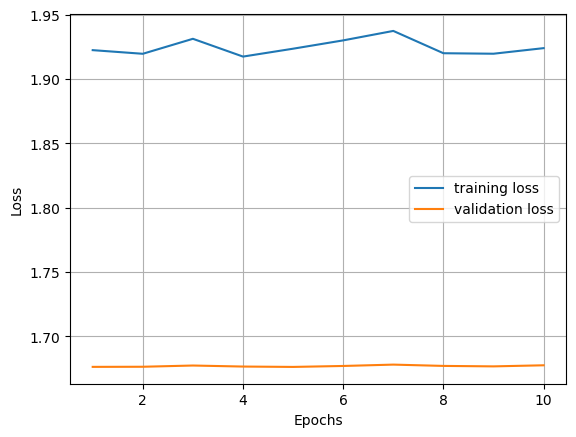

In [50]:
# Plot
x = np.arange(1, 11, 1)
# losses
plt.plot(x, train_losses, label='training loss')
plt.plot(x, val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [51]:
# Evaluate
model_gru_best = GRUNet(input_size=75, hidden_size=200, num_layers=1)
model_gru_best = model_gru_best.to(device)

checkpoint = torch.load('model_gru.pth.tar')
model_gru_best.load_state_dict(checkpoint['model'])

model_gru_best.eval()

print("GRU Evaluation Results:")

train_score = evaluate(train_loader_gru, model_gru_best).item()
val_score = evaluate(val_loader_gru, model_gru_best).item()

print(f"Train Loss: {train_score:.5f}")
print(f"Validate Loss: {val_score:.5f}")

GRU Evaluation Results:
Train Loss: 1.91916
Validate Loss: 1.67618


# Transformer

Welcome to the beginning of the real world! The aboved models are not usually used in practice due to its limited capability. Transformers are generally used by computer vision, natural language processing, and speech processing (almost every big AI fields).



In our dataloader, we will add the output of this timestep (the number of precipitation) as an auxiliary input to predict the next timestep. Thus, input for the model should be [#batch_size, 5, 76] (5 timesteps and the number 76 comes from (3x5x5)+1) and the output for the model should be [#batch_size, 1] which would be the next timestep we want to predict. Additionally, we will mask the input at the dataloader to the attenttion from observing future values. Suppose that we want to predict timestep 3, we will mask the timestep 3, 4 and 5 in our input by setting it to zeros, and we will predict the timestep 3.

In order to get a score on this TODO, students need to implement a dataloader that mask the input correctly.

(Note, in this homework, we ask you to mask the input which is simple to do. In practice, people prefer to mask the attention mask instead. This makes decoder-only architectures more parallelizable.)

In [52]:
################################################################################
# T17:                                                                        #
# Complete the code for preparing data for training Transformer                #
# Transformer's input should has 3 dimensions.                                 #
# The dimensions should compose of entries, time-step, and features.           #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class TransformerDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.from_numpy(x).float()
        self.y = torch.from_numpy(y).float()
    
    def __getitem__(self, index):
        img_seq = self.x[index]  # (5, 75)
        rain_seq = self.y[index] # (5, 1)
        # concat to get (5, 76)
        combined = torch.cat([img_seq, rain_seq], dim=1) # you can concat without leakage protection by shifting because the mask if you are predicting timestep 3 then the mask will mask 3,4,5 out.
        
        target_idx = np.random.randint(1, 5) # random to some kind of augmentation and the output will be that timestep
        
        masked_input = combined.clone()
        masked_input[target_idx:, :] = 0

        target_val = rain_seq[target_idx] # choose y at specific timestep to predict

        return masked_input, target_val

    def __len__(self):
        return self.x.shape[0]

# Use the same format as gru
train_dataset_tf = TransformerDataset(x_train_gru, y_train_gru)
val_dataset_tf = TransformerDataset(x_val_gru, y_val_gru)
test_dataset_tf = TransformerDataset(x_test_gru, y_test_gru)

# DataLoader
batch_size = 1024
train_loader_tf = DataLoader(train_dataset_tf, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader_tf = DataLoader(val_dataset_tf, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_tf = DataLoader(test_dataset_tf, batch_size=batch_size, shuffle=False, pin_memory=True)


In this task, we will implement one encoder layer of Transformer and add the linear layer to make a regression prediction. For the simplicity of the model, we will change the multi-head attention to QKV self-attention (single-head). As a result, our model should look like the diagram below. Since the layer self-attention is not availble in torch, students have to implement it themselves. In Add & Norm layer, students have to do the addition before normalizing. In Layer Normalization, we will normalize across both timesteps and features.

If you feel loss in this part of the assignment, watching this [video](https://www.youtube.com/watch?v=kCc8FmEb1nY) might help.

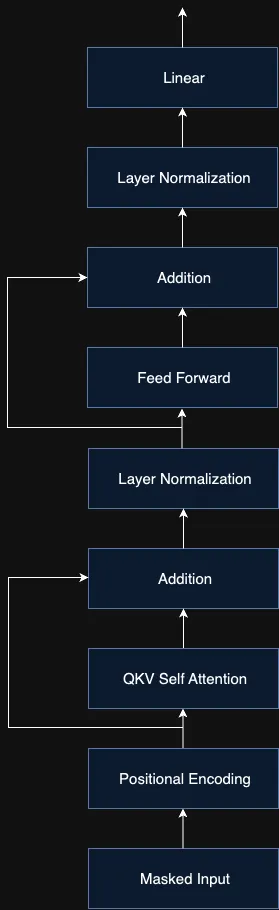

```
==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
==========================================================================================
TransformerModel                         [1024, 1]                 --
├─PositionalEncoding: 1-1                [1024, 5, 76]             --
│    └─Dropout: 2-1                      [1024, 5, 76]             --
├─SelfAttention: 1-2                     [1024, 5, 76]             --
│    └─Linear: 2-2                       [1024, 5, 76]             5,852
│    └─Linear: 2-3                       [1024, 5, 76]             5,852
│    └─Linear: 2-4                       [1024, 5, 76]             5,852
│    └─Softmax: 2-5                      [1024, 5, 5]              --
├─LayerNorm: 1-3                         [1024, 5, 76]             760
├─Linear: 1-4                            [1024, 5, 76]             5,852
├─LayerNorm: 1-5                         [1024, 5, 76]             760
├─Linear: 1-6                            [1024, 1]                 381
==========================================================================================
Total params: 25,309
Trainable params: 25,309
Non-trainable params: 0
Total mult-adds (M): 25.92
==========================================================================================
Input size (MB): 1.56
Forward/backward pass size (MB): 18.69
Params size (MB): 0.10
Estimated Total Size (MB): 20.34
==========================================================================================
```

In [53]:
################################################################################
# T18                                                                         #
# Write a PyTorch PositionalEncoding Layer.                                    #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
import math

class PositionalEncoding(nn.Module):
  def __init__(self, seq_len, emb_dim, dropout=0.2):
    # seq_len : length of input sequence
    # emb_dim : dimension of embedding
    super(PositionalEncoding, self).__init__()
    self.seq_len = seq_len
    self.emb_dim = emb_dim
    self.dropout = nn.Dropout(p=dropout)

    pe = torch.zeros(seq_len, emb_dim)

    for pos in range(seq_len):
      for i in range(0, emb_dim, 2): 
          div_term = 10000.0 ** (i / emb_dim) 
          pe[pos, i] = math.sin(pos / div_term)

          if i + 1 < emb_dim:
              pe[pos, i + 1] = math.cos(pos / div_term)
      
    pe = pe.unsqueeze(0) # (5, 76) -> (1, 5, 76) to be able to broadcast
    self.register_buffer('pe', pe)

  def forward(self, x):
    x = x + self.pe[:, :x.shape[1], :] # just in case the sequence length is not 5
    return self.dropout(x)

In [54]:
################################################################################
# T19                                                                         #
# Write a PyTorch Transformer model.                                           #
# Your goal is to predict a precipitation of every time step.                  #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
class SelfAttention(nn.Module):
    def __init__(self, input_dim):
        super(SelfAttention, self).__init__()
        self.input_dim = input_dim 

        self.query = nn.Linear(input_dim, input_dim)
        self.key = nn.Linear(input_dim, input_dim)
        self.value = nn.Linear(input_dim, input_dim)

        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: (Batch, Seq, Dim)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)

        # Q * K_transpose
        scores = torch.matmul(Q, K.transpose(-2, -1)) # transpose only seq and dim but not batch (5x5)

        scores = scores / np.sqrt(self.input_dim)
        attention = self.softmax(scores)

        context = torch.matmul(attention, V) # (5,5) * (5,76) = (5,76)
        return context

class TransformerModel(nn.Module):
    def __init__(self):
        super(TransformerModel, self).__init__()
        input_dim = 76
        seq_len = 5

        self.pe = PositionalEncoding(seq_len=seq_len, emb_dim=input_dim)
        self.sa = SelfAttention(input_dim)

        self.ln1 = nn.LayerNorm((seq_len, input_dim))
        self.feed_forward = nn.Linear(input_dim, input_dim) # torch will auto stack the sequence layer
        self.ln2 = nn.LayerNorm((seq_len, input_dim))
        self.final_linear = nn.Linear(input_dim * seq_len, 1)

    def forward(self, x):
        position_embedded = self.pe.forward(x)
        attentioned = self.sa.forward(position_embedded)
        attentioned += position_embedded
        norm1 = self.ln1(attentioned)
        fcn1 = self.feed_forward(norm1)
        fcn1 += norm1
        norm2 = self.ln2(fcn1)
        flatten = norm2.flatten(start_dim=1)
        output = self.final_linear(flatten)
        
        return output       

In [55]:
model_tfm = TransformerModel()
model_tfm = model_tfm.to(device)

summary(model_tfm, input_size=(1024, 5, 76))

Layer (type:depth-idx)                   Output Shape              Param #
TransformerModel                         [1024, 1]                 --
├─PositionalEncoding: 1-1                --                        --
│    └─Dropout: 2-1                      [1024, 5, 76]             --
├─SelfAttention: 1-2                     --                        --
│    └─Linear: 2-2                       [1024, 5, 76]             5,852
│    └─Linear: 2-3                       [1024, 5, 76]             5,852
│    └─Linear: 2-4                       [1024, 5, 76]             5,852
│    └─Softmax: 2-5                      [1024, 5, 5]              --
├─LayerNorm: 1-3                         [1024, 5, 76]             760
├─Linear: 1-4                            [1024, 5, 76]             5,852
├─LayerNorm: 1-5                         [1024, 5, 76]             760
├─Linear: 1-6                            [1024, 1]                 381
Total params: 25,309
Trainable params: 25,309
Non-trainable params: 0


In [56]:
################################################################################
# T20                                                                         #
# Complete the code to train your Transformer model                                    #
################################################################################
print('start training transformer')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'Transformer', 
    'lr': 0.001,
    'hidden_size': 76, 
    'seq_len': 5,
    'epochs': 10,
    'scheduler_factor': 0.5,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-6,
}

optimizer = torch.optim.Adam(model_tfm.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr'],
)

run = wandb.init(
    project="precipitation-nowcasting",
    config=config,
)
wandb.watch(model_tfm, log='all')

train_losses = []
val_losses = []
best_val_loss = np.inf

print('Start training Transformer')

for epoch in range(config['epochs']):
    train_loss = []

    model_tfm.train()

    for i, (inputs, targets) in enumerate(tqdm(train_loader_tf)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model_tfm(inputs)

        loss = loss_fn(outputs, targets)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    model_tfm.eval()
    val_loss = []
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader_tf)): 
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model_tfm(inputs)
            loss = loss_fn(outputs, targets)
            val_loss.append(loss)

    avg_val_loss = torch.stack(val_loss).mean().item()
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        state = {
            'epoch': epoch,
            'model': model_tfm.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'config': config
        }
        print(f"Saving new best Transformer model (Loss: {best_val_loss:.4f})..")
        torch.save(state, 'model_tfm.pth.tar')

    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': optimizer.param_groups[0]['lr']
    })

wandb.finish()
print("Finished Training Transformer")

start training transformer


Start training Transformer


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.8016


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.8231
Saving new best Transformer model (Loss: 1.8231)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9843


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.7750
Saving new best Transformer model (Loss: 1.7750)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.7859


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6868
Saving new best Transformer model (Loss: 1.6868)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.7980


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6923


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9493


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6833
Saving new best Transformer model (Loss: 1.6833)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9995


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.7461


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 2.0187


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.5789
Saving new best Transformer model (Loss: 1.5789)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.7840


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6771


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 2.1236


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6432


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.8600


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6987


lr,█████████▁
train_loss,▁▅▁▁▄▅▆▁█▃
val_loss,█▇▄▄▄▆▁▄▃▄
lr,0.0005
train_loss,1.86004
val_loss,1.69871


Finished Training Transformer


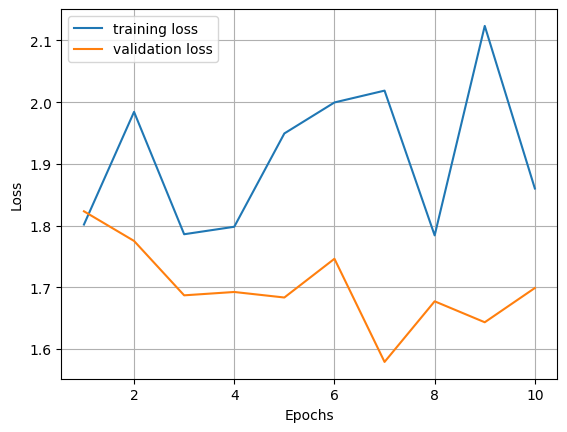

In [57]:
# Plot
x = np.arange(1, 11, 1)
# losses
plt.plot(x, train_losses, label='training loss')
plt.plot(x, val_losses, label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

If you implement it correctly, you should evaluate the model in the test dataset and the score should be better than the aboved models.

In [58]:
# Evaluate
model_tfm_best = TransformerModel()
model_tfm_best = model_tfm_best.to(device)

checkpoint = torch.load('model_tfm.pth.tar')
model_tfm_best.load_state_dict(checkpoint['model'])

model_tfm_best.eval()

print("Transformer Model")
train_score = evaluate(train_loader_tf, model_tfm_best).item()
val_score = evaluate(val_loader_tf, model_tfm_best).item()

print(f"Train Loss: {train_score:.5f}")
print(f"Validate Loss: {val_score:.5f}")

Transformer Model
Train Loss: 1.97030
Validate Loss: 1.85492


# Final Section
# PyTorch playground

Now, train the best model you can do for this task. You can use any model structure and function available.    
Remember that trainig time increases with the complexity of the model. You might find printing computation graphs helpful in debugging complicated models.    
Your model should be better than your CNN or Transformer model in the previous sections.

Some ideas:

- Tune the hyperparameters
- Adding dropouts
- Combining different types of models

You should tune your model on training and validation set.    
**The test set should be used only for the last evaluation.**

In [59]:
def preprocess_for_best(x_train, y_train, x_val, y_val, x_test, y_test):
    # reshape to (batch, time, height, width, channel) -> (batch, time, channel, height, width)
    x_train_best = x_train.reshape(-1, 5, 5, 5, 3).transpose(0, 1, 4, 2, 3)
    y_train_best = y_train.reshape(-1, 5, 1)
    
    x_val_best = x_val.reshape(-1, 5, 5, 5, 3).transpose(0, 1, 4, 2, 3)
    y_val_best = y_val.reshape(-1, 5, 1)
    
    x_test_best = x_test.reshape(-1, 5, 5, 5, 3).transpose(0, 1, 4, 2, 3)
    y_test_best = y_test.reshape(-1, 5, 1)
    
    return x_train_best, y_train_best, x_val_best, y_val_best, x_test_best, y_test_best


x_train_best, y_train_best, x_val_best, y_val_best, x_test_best, y_test_best = preprocess_for_best(x_train, y_train, x_val, y_val, x_test, y_test)

print("x_train_best shape:", x_train_best.shape)
print("y_train_best shape:", y_train_best.shape)

class BestDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x).float() if not torch.is_tensor(x) else x.float()
        self.y = torch.tensor(y).float() if not torch.is_tensor(y) else y.float()

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.x.shape[0]

train_dataset_best = BestDataset(x_train_best, y_train_best)
val_dataset_best = BestDataset(x_val_best, y_val_best)
test_dataset_best = BestDataset(x_test_best, y_test_best)

batch_size = 1024
train_loader_best = DataLoader(train_dataset_best, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader_best = DataLoader(val_dataset_best, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader_best = DataLoader(test_dataset_best, batch_size=batch_size, shuffle=False, pin_memory=True)

x_train_best shape: (229548, 5, 3, 5, 5)
y_train_best shape: (229548, 5, 1)


In [60]:
################################################################################
# T21                                                                     #
# Write a function that returns your best PyTorch model. You can use anything  #
# you want. The goal here is to create the best model you can think of.        #
#                                                                              #
# Hint: You should read PyTorch documentation to see the list of available     #
# layers and options you can use.                                              #
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
import math

class PositionalEncodingBest(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncodingBest, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class ConvTransformer(nn.Module):
    def __init__(self, cnn_out_dim=64, d_model=128, nhead=4, num_layers=2):
        super(ConvTransformer, self).__init__()
        
        self.cnn_out_dim = cnn_out_dim
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, self.cnn_out_dim, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(self.cnn_out_dim)
        )
        
        self.fc_cnn = nn.Linear(self.cnn_out_dim * 5 * 5, self.d_model)
        
        self.pos_encoder = PositionalEncodingBest(self.d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.nhead, batch_first=False)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=self.num_layers)
        
        self.decoder = nn.Sequential(
            nn.Linear(self.d_model, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.reshape(b * t, c, h, w) 
        
        x = self.cnn(x)
        x = x.reshape(b, t, -1) 

        x = self.fc_cnn(x)

        x = x.permute(1, 0, 2) 
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)

        x = x.permute(1, 0, 2) 
        out = self.decoder(x)
        return out

model_best = ConvTransformer().to(device)
print(model_best)

ConvTransformer(
  (cnn): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc_cnn): Linear(in_features=1600, out_features=128, bias=True)
  (pos_encoder): PositionalEncodingBest()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=128, bias=True)
        (norm1): LayerNorm((128,

c:\Users\Faith\miniconda3\envs\pattern\lib\site-packages\torch\nn\modules\transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [61]:
################################################################################
# T22                                                                    #
# Complete the code to train your best model                                   #
################################################################################
print('start training the best model')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'ConvTransformer', 
    'lr': 0.001,
    'hidden_size': 128,
    'seq_len': 5,
    'epochs': 70,
    'scheduler_factor': 0.5,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-6,
}

optimizer = torch.optim.Adam(model_best.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr'],
)

run = wandb.init(
    project="precipitation-nowcasting",
    config=config,
    reinit=True
)
wandb.watch(model_best, log='all')

train_losses = []
val_losses = []
best_val_loss = np.inf

print('Start training Best Model')

for epoch in range(config['epochs']):
    train_loss = []

    model_best.train() 

    for i, (inputs, targets) in enumerate(tqdm(train_loader_best)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model_best(inputs) 

        loss = loss_fn(outputs, targets)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    model_best.eval()
    val_loss = []
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader_best)): 
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model_best(inputs)
            loss = loss_fn(outputs, targets)
            val_loss.append(loss)

    avg_val_loss = torch.stack(val_loss).mean().item()
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        state = {
            'epoch': epoch,
            'model': model_best.state_dict(), 
            'optimizer': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'config': config
        }
        print(f"Saving new best model (Loss: {best_val_loss:.4f})..")
        torch.save(state, 'model_best.pth.tar')
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': optimizer.param_groups[0]['lr']
    })

wandb.finish()
print("Finished Training")

start training the best model


wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


Start training Best Model


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9286


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6748
Saving new best model (Loss: 1.6748)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9154


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6833


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9103


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6819


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9138


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6778


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9115


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6685
Saving new best model (Loss: 1.6685)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9108


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6679
Saving new best model (Loss: 1.6679)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9182


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6699


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9320


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6716


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9120


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6687


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9135


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6673
Saving new best model (Loss: 1.6673)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 11 train loss: 1.9071


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11 val loss: 1.6689


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 12 train loss: 1.9066


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 12 val loss: 1.6669
Saving new best model (Loss: 1.6669)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 13 train loss: 1.9061


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 13 val loss: 1.6682


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 14 train loss: 1.9172


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 14 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 15 train loss: 1.9121


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 15 val loss: 1.6690


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 16 train loss: 1.9107


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 16 val loss: 1.6687


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 17 train loss: 1.9098


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 17 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 18 train loss: 1.9039


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 18 val loss: 1.6676


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 19 train loss: 1.9111


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 19 val loss: 1.6689


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 20 train loss: 1.9065


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 20 val loss: 1.6692


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 21 train loss: 1.9082


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 21 val loss: 1.6680


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 22 train loss: 1.9106


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 22 val loss: 1.6677


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 23 train loss: 1.9023


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 23 val loss: 1.6673


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 24 train loss: 1.9257


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 24 val loss: 1.6676


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 25 train loss: 1.9040


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 25 val loss: 1.6677


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 26 train loss: 1.9031


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 26 val loss: 1.6684


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 27 train loss: 1.9011


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 27 val loss: 1.6681


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 28 train loss: 1.9140


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 28 val loss: 1.6682


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 29 train loss: 1.9031


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 29 val loss: 1.6684


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 30 train loss: 1.9290


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 30 val loss: 1.6674


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 31 train loss: 1.9260


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 31 val loss: 1.6694


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 32 train loss: 1.9197


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 32 val loss: 1.6681


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 33 train loss: 1.9092


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 33 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 34 train loss: 1.9033


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 34 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 35 train loss: 1.9006


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 35 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 36 train loss: 1.9038


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 36 val loss: 1.6683


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 37 train loss: 1.9018


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 37 val loss: 1.6683


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 38 train loss: 1.9038


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 38 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 39 train loss: 1.9026


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 39 val loss: 1.6682


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 40 train loss: 1.9062


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 40 val loss: 1.6681


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 41 train loss: 1.9024


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 41 val loss: 1.6683


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 42 train loss: 1.9087


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 42 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 43 train loss: 1.9013


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 43 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 44 train loss: 1.9036


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 44 val loss: 1.6684


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 45 train loss: 1.9078


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 45 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 46 train loss: 1.9014


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 46 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 47 train loss: 1.9018


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 47 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 48 train loss: 1.9031


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 48 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 49 train loss: 1.9022


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 49 val loss: 1.6684


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 50 train loss: 1.9091


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 50 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 51 train loss: 1.9044


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 51 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 52 train loss: 1.9153


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 52 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 53 train loss: 1.9014


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 53 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 54 train loss: 1.9036


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 54 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 55 train loss: 1.9023


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 55 val loss: 1.6684


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 56 train loss: 1.9191


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 56 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 57 train loss: 1.9009


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 57 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 58 train loss: 1.9034


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 58 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 59 train loss: 1.9044


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 59 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 60 train loss: 1.9088


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 60 val loss: 1.6682


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 61 train loss: 1.9141


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 61 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 62 train loss: 1.9130


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 62 val loss: 1.6687


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 63 train loss: 1.9054


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 63 val loss: 1.6689


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 64 train loss: 1.9008


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 64 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 65 train loss: 1.9090


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 65 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 66 train loss: 1.9232


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 66 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 67 train loss: 1.9020


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 67 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 68 train loss: 1.9104


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 68 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 69 train loss: 1.9055


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 69 val loss: 1.6684


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 70 train loss: 1.9005


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 70 val loss: 1.6688


lr,██▄▄▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▅▄▄▄▄▄▂▅▄▂▄▂▃▇▂▁▄▂█▆▃▂▁▁▂▁▃▁▂▁▃▅▁▂▂▄▄▁▁
val_loss,▅█▂▂▃▁▂▂▁▂▁▁▁▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
lr,0.0
train_loss,1.90051
val_loss,1.66885


Finished Training


In [62]:
# Evaluate best model on validation and test set
model_best = ConvTransformer().to(device)
checkpoint = torch.load('model_best.pth.tar')
model_best.load_state_dict(checkpoint['model'])
model_best.eval()
print("Validate:", evaluate(val_loader_best, model_best).item())
print("Test:", evaluate(test_loader_best, model_best).item())

Validate: 1.666916847229004
Test: 1.1507755517959595


In [63]:
# Also evaluate your fully-connected model and CNN/GRU/Transformer model on the test set.
model_ff = FeedForwardNN(hidden_size=200) 
model_ff = model_ff.to(device)
checkpoint = torch.load('model_ff.pth.tar')
model_ff.load_state_dict(checkpoint['model'])
model_ff.eval()
print("FCN: ", evaluate(test_loader, model_ff).item())

FCN:  1.161521077156067


In [64]:
model_wd = FeedForwardNNwithDropout(hidden_size=200) 
model_wd = model_wd.to(device)
checkpoint = torch.load('model_wd.pth.tar')
model_wd.load_state_dict(checkpoint['model'])
model_wd.eval()
print("FCN with Dropout: ", evaluate(test_loader, model_wd).item())

FCN with Dropout:  1.1640076637268066


In [65]:
model_cnn_clean = ConvNN()
model_cnn_clean = model_cnn_clean.to(device)
checkpoint = torch.load('model_cnn.pth.tar')
model_cnn_clean.load_state_dict(checkpoint['model'])
model_cnn_clean.eval()
print("CNN: ", evaluate(test_loader_conv, model_cnn_clean).item())

CNN:  1.1611624956130981


In [66]:
model_gru_best = GRUNet(input_size=75, hidden_size=200, num_layers=1)
model_gru_best = model_gru_best.to(device)
checkpoint = torch.load('model_gru.pth.tar')
model_gru_best.load_state_dict(checkpoint['model'])
model_gru_best.eval()
print("GRU: ", evaluate(test_loader_gru, model_gru_best).item())

GRU:  1.1549108028411865


In [96]:
model_tfm_best = TransformerModel()
model_tfm_best = model_tfm_best.to(device)
checkpoint = torch.load('model_tfm.pth.tar')
model_tfm_best.load_state_dict(checkpoint['model'])
model_tfm_best.eval()
print("Transformer: ", evaluate(test_loader_tf, model_tfm_best).item())

Transformer:  1.1705740690231323


To get full credit for this part, your best model should be better than the previous models on the **test set**.

### T23

Explain what helped and what did not help here

**Ans:**

    - Mixing convolution with transformers help, and it 
    gets the best score amongs every models.

    - Changing the number of epochs, but it didn't help
    much on the validation set.
    
    - Adding number of convolutional layer also didn't help.

# [Optional] Augmentation using data loader

### OT5

Implement a new dataloader on your best model that will perform data augmentation. Try adding noise of zero mean and variance of $10e^{-2}$.

Then, train your model.

In [68]:
# Write Dataset/DataLoader with noise here
from torch.utils.data import Dataset, DataLoader
import numpy as np

class NoisyDataset(Dataset):
    def __init__(self, original_dataset, variance=10e-2):
        self.dataset = original_dataset
        self.std = variance ** 0.5 
        
    def __getitem__(self, index):
        x, y = self.dataset[index]
        noise = torch.randn_like(x) * self.std
        x_noisy = x + noise
        return x_noisy, y

    def __len__(self):
        return len(self.dataset)

train_dataset_noise = NoisyDataset(train_dataset, variance=10e-2)

train_loader_noise = DataLoader(train_dataset_noise, batch_size=1024, shuffle=True, pin_memory=True)

print(f"Noisy Train size: {len(train_dataset_noise)}")
print(f"Noise Variance: {10e-2}, Std Dev: {(10e-2)**0.5:.4f}")

Noisy Train size: 1147740
Noise Variance: 0.1, Std Dev: 0.3162


In [69]:
print('start training the best model with noise')
################################################################################
#                            WRITE YOUR CODE BELOW                             #
################################################################################
config = {
    'architecture': 'ConvTransformer', 
    'lr': 0.001,
    'hidden_size': 128,
    'seq_len': 5,
    'epochs': 70,
    'scheduler_factor': 0.5,
    'scheduler_patience': 2,
    'scheduler_min_lr': 1e-6,
}

optimizer = torch.optim.Adam(model_best.parameters(), lr=config['lr'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 'min',
    factor=config['scheduler_factor'],
    patience=config['scheduler_patience'],
    min_lr=config['scheduler_min_lr'],
)

run = wandb.init(
    project="precipitation-nowcasting",
    config=config,
    reinit=True
)
wandb.watch(model_best, log='all')

train_losses = []
val_losses = []
best_val_loss = np.inf

print('Start training Best Model')

for epoch in range(config['epochs']):
    train_loss = []

    model_best.train() 

    for i, (inputs, targets) in enumerate(tqdm(train_loader_best)):
        inputs = inputs.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        outputs = model_best(inputs) 

        loss = loss_fn(outputs, targets)
        train_loss.append(loss)
        loss.backward()
        optimizer.step()

    avg_train_loss = torch.stack(train_loss).mean().item()
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1} train loss: {avg_train_loss:.4f}")

    model_best.eval()
    val_loss = []
    
    with torch.no_grad():
        for i, (inputs, targets) in enumerate(tqdm(val_loader_best)): 
            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model_best(inputs)
            loss = loss_fn(outputs, targets)
            val_loss.append(loss)

    avg_val_loss = torch.stack(val_loss).mean().item()
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch+1} val loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        state = {
            'epoch': epoch,
            'model': model_best.state_dict(), 
            'optimizer': optimizer.state_dict(),
            'val_loss': best_val_loss,
            'config': config
        }
        print(f"Saving new best model (Loss: {best_val_loss:.4f})..")
        torch.save(state, 'model_best_noise.pth.tar')
    wandb.log({
        'train_loss': avg_train_loss,
        'val_loss': avg_val_loss,
        'lr': optimizer.param_groups[0]['lr']
    })

wandb.finish()
print("Finished Training")

start training the best model with noise


Start training Best Model


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 1 train loss: 1.9143


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 1 val loss: 1.6749
Saving new best model (Loss: 1.6749)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 2 train loss: 1.9234


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 2 val loss: 1.6701
Saving new best model (Loss: 1.6701)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 3 train loss: 1.9131


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 3 val loss: 1.6744


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 4 train loss: 1.9291


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 4 val loss: 1.6687
Saving new best model (Loss: 1.6687)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 5 train loss: 1.9102


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 5 val loss: 1.6719


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 6 train loss: 1.9156


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 6 val loss: 1.6818


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 7 train loss: 1.9138


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 7 val loss: 1.6747


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 8 train loss: 1.9182


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 8 val loss: 1.6730


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 9 train loss: 1.9113


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 9 val loss: 1.6699


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 10 train loss: 1.9133


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 10 val loss: 1.6707


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 11 train loss: 1.9153


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 11 val loss: 1.6700


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 12 train loss: 1.9207


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 12 val loss: 1.6697


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 13 train loss: 1.9148


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 13 val loss: 1.6712


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 14 train loss: 1.9129


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 14 val loss: 1.6710


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 15 train loss: 1.9094


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 15 val loss: 1.6689


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 16 train loss: 1.9122


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 16 val loss: 1.6685
Saving new best model (Loss: 1.6685)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 17 train loss: 1.9149


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 17 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 18 train loss: 1.9170


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 18 val loss: 1.6706


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 19 train loss: 1.9138


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 19 val loss: 1.6690


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 20 train loss: 1.9176


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 20 val loss: 1.6680
Saving new best model (Loss: 1.6680)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 21 train loss: 1.9163


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 21 val loss: 1.6693


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 22 train loss: 1.9092


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 22 val loss: 1.6689


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 23 train loss: 1.9104


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 23 val loss: 1.6683


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 24 train loss: 1.9120


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 24 val loss: 1.6680


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 25 train loss: 1.9087


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 25 val loss: 1.6680


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 26 train loss: 1.9170


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 26 val loss: 1.6677
Saving new best model (Loss: 1.6677)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 27 train loss: 1.9137


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 27 val loss: 1.6674
Saving new best model (Loss: 1.6674)..


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 28 train loss: 1.9058


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 28 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 29 train loss: 1.9060


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 29 val loss: 1.6688


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 30 train loss: 1.9073


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 30 val loss: 1.6686


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 31 train loss: 1.9330


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 31 val loss: 1.6682


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 32 train loss: 1.9077


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 32 val loss: 1.6685


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 33 train loss: 1.9090


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 33 val loss: 1.6681


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 34 train loss: 1.9076


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 34 val loss: 1.6680


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 35 train loss: 1.9096


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 35 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 36 train loss: 1.9065


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 36 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 37 train loss: 1.9074


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 37 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 38 train loss: 1.9112


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 38 val loss: 1.6677


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 39 train loss: 1.9159


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 39 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 40 train loss: 1.9072


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 40 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 41 train loss: 1.9088


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 41 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 42 train loss: 1.9113


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 42 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 43 train loss: 1.9126


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 43 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 44 train loss: 1.9098


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 44 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 45 train loss: 1.9119


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 45 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 46 train loss: 1.9062


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 46 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 47 train loss: 1.9241


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 47 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 48 train loss: 1.9080


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 48 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 49 train loss: 1.9086


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 49 val loss: 1.6680


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 50 train loss: 1.9073


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 50 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 51 train loss: 1.9077


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 51 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 52 train loss: 1.9137


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 52 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 53 train loss: 1.9062


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 53 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 54 train loss: 1.9108


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 54 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 55 train loss: 1.9062


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 55 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 56 train loss: 1.9078


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 56 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 57 train loss: 1.9087


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 57 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 58 train loss: 1.9180


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 58 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 59 train loss: 1.9091


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 59 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 60 train loss: 1.9061


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 60 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 61 train loss: 1.9114


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 61 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 62 train loss: 1.9058


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 62 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 63 train loss: 1.9074


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 63 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 64 train loss: 1.9213


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 64 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 65 train loss: 1.9076


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 65 val loss: 1.6677


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 66 train loss: 1.9124


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 66 val loss: 1.6679


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 67 train loss: 1.9066


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 67 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 68 train loss: 1.9279


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 68 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 69 train loss: 1.9262


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 69 val loss: 1.6678


  0%|          | 0/225 [00:00<?, ?it/s]

Epoch 70 train loss: 1.9123


  0%|          | 0/91 [00:00<?, ?it/s]

Epoch 70 val loss: 1.6678


lr,█████▃▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▄▃█▂▄▃▄▅▄▃▄▅▄▂▃▄▃▁▁▁▂▁▁▃▂▂▇▂▁▂▁▃▁▂▅▁▆▂▃▇
val_loss,▅▄█▄▄▃▂▃▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr,0.0
train_loss,1.91227
val_loss,1.66781


Finished Training


In [71]:
# Evaluate the best model trained with noise on validation and test set
model_best = ConvTransformer().to(device)
checkpoint = torch.load('model_best_noise.pth.tar')
model_best.load_state_dict(checkpoint['model'])
model_best.eval()
print("Validate:", evaluate(val_loader_best, model_best).item())
print("Test:", evaluate(test_loader_best, model_best).item())

Validate: 1.6674202680587769
Test: 1.15091073513031
